<b>Purpose of this notebook:</b>
* take in churning dataset and analyse precision and recall for different thresholds

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/churn_data.csv')

In [3]:
#change dtype of 'TotalCharges' from object to numeric
#if there is an error, because the value has a space (" "), we use --> errors='coerce'
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [4]:
#set missing values to zero
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [5]:
#column names & string values: lowercasing everything and replace spaces with underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
#change target variable from object to integer (if yes, then 1; if no, then 0)
df.churn = (df.churn == 'yes').astype(int)

In [7]:
#splitting the dataset in different subsets
from sklearn.model_selection import train_test_split

#shuffling the data of df and splitting it into 2 sets
#df_train_full (80%), df_test(20%)
#random_state guarantees that the data is always shuffled in the same way
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

#take df_train_full and split it into train and val
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

#save target variable in a matrix array
y_train = df_train.churn.values
y_val = df_val.churn.values

#delete target variable from training and validation set
del df_train['churn']
del df_val['churn']

In [8]:
#create variable lists
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
'phoneservice', 'multiplelines', 'internetservice',
'onlinesecurity', 'onlinebackup', 'deviceprotection',
'techsupport', 'streamingtv', 'streamingmovies',
'contract', 'paperlessbilling', 'paymentmethod']

numerical = ['tenure', 'monthlycharges', 'totalcharges']


In [9]:
def prepare_X(df):
    #convert training set to dictionary
    train_dict = df[categorical + numerical].to_dict(orient='rows')
    from sklearn.feature_extraction import DictVectorizer
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    #use 'transform' method to convert dictionaries to matrix
    X = dv.transform(train_dict)
    return X

#train logictic regression model
from sklearn.linear_model import LogisticRegression
#train model by calling the 'fit' method
#X_train is derived from training set (besides we also have validation and testing set)
model = LogisticRegression(solver='liblinear', random_state = 1)
model.fit(prepare_X(df_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
def prepare_val(df_inp):
    #convert training set to dictionary
    train_dict = df_inp[categorical + numerical].to_dict(orient='rows')
    from sklearn.feature_extraction import DictVectorizer
    dv_new = DictVectorizer(sparse=False)
    dv_new.fit(train_dict)
    #use 'transform' method to convert dictionaries to matrix
    X = dv_new.transform(train_dict)
    return X

y_pred = model.predict_proba(prepare_val(df_val))[:, 1]

In [11]:
from sklearn.metrics import accuracy_score
#loop over different thresholds and see what has the best accuracy
#a threshold of 0.5 gives us the best accuracy
thresholds = np.linspace(0, 1, 11) #this gives 11 numbers starting with 0.0, 0.1, 0.2, ...
for t in thresholds:
    #compute accuracy
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    #print results
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


In [12]:
#calculate 4 outcomes
#make prediction at threshold 0.5
t = 0.5
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)

#get the actual target values
actual_churn = (y_val == 1)
actual_no_churn =(y_val == 0)

#calculate true and false positives
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()

#calculate false and true negatives
#the logical "and" operator only evaluates to true if both values are true
false_negative = (predict_no_churn & actual_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()


In [13]:
#put all 4 values in one numpy array
confusion_table = np.array(
[[true_negative, false_positive],
[false_negative, true_positive]])
confusion_table

array([[1202,  172],
       [ 197,  289]])

In [14]:
#computing confusion table for different thresholds

#result list
scores = []
#create array with different threshold values
thresholds = np.linspace(0, 1, 101)

#compute confusion table for predictions at each threshold
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    #append results to scores list
    scores.append((t, tp, fp, fn, tn))

In [15]:
#convert list of tuples to dataframe
df_scores = pd.DataFrame(scores)
#give names to the columns
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [16]:
#compute precision and recall
#and add it to the df
df_scores['prec'] = (df_scores.tp / (df_scores.tp + df_scores.fp)).round(2)
df_scores['rec'] = (df_scores.tp / (df_scores.tp + df_scores.fn)).round(2)

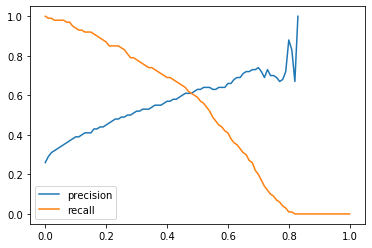

In [17]:
#plot the values
plt.plot(df_scores.threshold, df_scores.prec, label="precision")
plt.plot(df_scores.threshold, df_scores.rec, label="recall")
plt.legend()

* precision helps us to understand how many customers received promotional messages per mistake (actually they are not going to churn); or: how many of the positive predictions are correct
* recall helps us to understand how many of the churning customers haven't been identified by the model
* with a threshold = 0, all customers are predicted as churning (positivie predictions),
but many are wrong (FP), so the precision is small at a threshold =0
* with a threshold = 0, we can correctly predict all churning customers,
and because the denominator is standing for all positive examples (y_val == 1),
the precision equals 1 at a threshold =0


In [18]:
#get row of df where prec equals rec
#https://stackoverflow.com/questions/48751140/pandas-select-rows-where-two-columns-are-different
df_scores.query('prec == rec')

,threshold,tp,fp,fn,tn,prec,rec
48,0.48,298,189,188,1185,0.61,0.61


Use the F1 score to overcome the precision recall tradeoff
* F1 = 2 * P * R / (P + R)
* identify the threshold where F1 is max

In [19]:
#calculate F1 score
df_scores['f1'] = (2 * df_scores.prec * df_scores.rec) / (df_scores.prec + df_scores.rec)

In [20]:
#find threshold where F1 is max
df_scores.loc[df_scores['f1'] == df_scores['f1'].max()] 

,threshold,tp,fp,fn,tn,prec,rec,f1
36,0.36,353,293,133,1081,0.55,0.73,0.627344


If we have a highly imbalanced dataset (1000 negatives, 1 positive), AU ROC<br>
could be problematic. Here we can use AU PR (area under precision recall curve)
* recall is plotted on x-axis
* precision is plotted on y-axis
* task: plot PR curve, calculate AU PR score and compare it with random & ideal model

In [21]:
#prepare random model

#fix random seed for reproducibility
np.random.seed(1)
#generate array with random numbers between 0 and 1
#y_rand contains the "predictions of our model"
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [22]:
#calculate precision and recall at different thresholds

#generate function what takes in actual and predicted values
def prec_rec_dataframe(y_val, y_pred):
    #calculate confusion table for different thresholds
    scores = []
    thresholds = np.linspace(0, 1, 101)
    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    #convert confusion table numbers to dataframe and give columns a name
    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    
    #calculate precision & recall
    df_scores['prec'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['rec'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [23]:
#use function to calculate precision and recall for random model
df_rand = prec_rec_dataframe(y_val, y_rand)

In [24]:
#generate ideal predictions
#generate array with fake target variables, that are already ordered
#it firstly only contains 0's, then it only contains 1's

#calculate number of negative and positive examples in dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

#generate array that firstly repeates 0s num_neg number of times,
#then generates 1s repeated num_pos number of times
y_ideal = np.repeat([0,1], [num_neg, num_pos])

#generate "predicitions of the model"：numbers that grow 
#from 0 in first cell to 1 in last cell
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

#calculate precision and recall for this model
df_ideal = prec_rec_dataframe(y_ideal, y_pred_ideal)

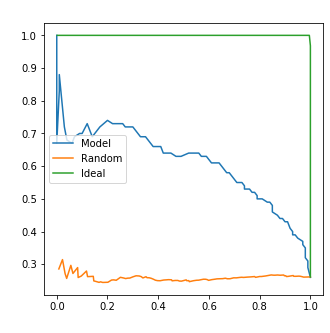

In [25]:
#create PR curve

#prepare plot square
plt.figure(figsize=(5, 5))
#plot PR curve for the model
plt.plot(df_scores.rec, df_scores.prec, label='Model')
#plot PR curve for the random baseline model
plt.plot(df_rand.rec, df_rand.prec, label='Random')
#plot PR curve for the ideal ranking model
plt.plot(df_ideal.rec, df_ideal.prec, label='Ideal')
plt.xlabel('Recall', color='white')
plt.ylabel('Precision', color='white')
plt.title('PR Curve', color='white')

plt.legend()


In [26]:
df_scores.head()

,threshold,tp,fp,fn,tn,prec,rec,f1
0,0.00,486,1374,0,0,0.26,1.00,0.412698
1,0.01,483,1190,3,184,0.29,0.99,0.448594
2,0.02,481,1074,5,300,0.31,0.99,0.472154
3,0.03,478,1011,8,363,0.32,0.98,0.482462
4,0.04,478,970,8,404,0.33,0.98,0.493740
